In [77]:
import csv
import math as m
from random import uniform as unif
import networkx as nx

import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
expid = "./exp1_run2"

In [79]:
if not os.path.exists(expid):
    os.makedirs(expid)

# Problem instance

## Geographic data

In [80]:
from pkg.read_problem import read_problem, extract_problem

In [81]:
xy_customers, xy_icps, xy_crcs, xy_pc, q = read_problem('./datasets/original')

In [82]:
xy_icps = xy_icps + [[unif(20,100),unif(20,70)] for i in range(10)]
xy_crcs = xy_crcs + [[unif(20,100),unif(20,70)] for i in range(5)]

In [83]:
I,J,C,B,K,V,W,Dcj,Dc,FCV,FCT,FCR,q = extract_problem(xy_customers, xy_icps, xy_crcs, xy_pc, q)

## Capacity constraints

In [84]:
Q = [200 for j in range(J)]
V = [[200 for j in range(J)],[800 for c in range(C)]]

## Adapting costs

In [85]:
# two-level cost
FCRD = []
for c in range(C):
    FCRD.append(FCR[c] + Dc[c])

f = FCT+FCRD
c = [[[W[i][j1] + Dcj[j1][j2] for j2 in range(C)] for j1 in range(J)] for i in range(I)]

# Plot Problem

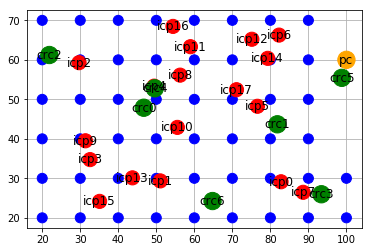

In [86]:
from pkg.lrp_nodes_graph import lrp_nodes_graph, lrp_draw_and_save
G, pos, labels, colors, size = lrp_nodes_graph(xy_customers, xy_icps, xy_crcs, xy_pc)

lrp_draw_and_save(G, pos, labels, colors, size, expid+"/problem.png")

# Define Functions

## run_uflp_cplex

In [87]:
def run_uflp_cplex(G,I,J,W,FCT,expid):
    from pkg.uflp_cplex import uflp_cplex

    prob, Y, N_icp = uflp_cplex(I,J,
                W,FCT,
                relaxation=False,path=expid+"/uflp_cplex.lp")

    G2 = G.copy()

    for j,vj in enumerate(Y):
        for i,vi in enumerate(vj):
            if vi == 1:
                G2.add_edge(I+i,j)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/uflp_cplex.png")

## run_cflp_cplex

In [88]:
def run_cflp_cplex(G,I,J,W,FCT,U,Q,expid):
    from pkg.cflp_cplex import cflp_cplex

    prob, Y, N_icp = cflp_cplex(I,J,
                W,FCT,U,Q,
                relaxation=False,path=expid+"/cflp_cplex.lp")

    G2 = G.copy()

    for j,vj in enumerate(Y):
        for i,vi in enumerate(vj):
            if vi == 1:
                G2.add_edge(I+i,j)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/cflp_cplex.png")

## run_tuflp_cplex

In [89]:
def run_tuflp_cplex(G,I,J,C,c,f,expid):
    from pkg.tuflp_cplex import tuflp_cplex

    prob, X, Z = tuflp_cplex(I,J,C,c,f,
                relaxation=False,path=expid+"/tcflp_cplex.lp")


    G2 = G.copy()

    for i in range(I):
        for j1 in range(J):
            for j2 in range(C):
                if X[i][j1][j2] == 1:
                    G2.add_edge(i,I+j1)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/tcflp_cplex.png")

## run_tecflp_cplex

In [90]:
def run_tecflp_cplex(G,I,J,C,c,f,q,V,expid):
    from pkg.tecflp_cplex import tecflp_cplex

    prob, X, Z = tecflp_cplex(I,J,C,c,f,q,V,
                relaxation=False,path=expid+"/tecflp_cplex.lp")

    G2 = G.copy()

    for i in range(I):
        for j1 in range(J):
            for j2 in range(C):
                if X[i][j1][j2] == 1:
                    G2.add_edge(i,I+j1)

    lrp_draw_and_save(G2, pos, labels, colors, size, expid+"/tecflp_cplex.png")

# Run experiment

1 loop, best of 3: 567 ms per loop


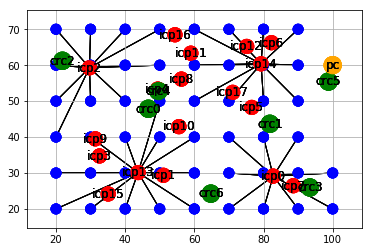

In [91]:
result1 = %timeit -o run_uflp_cplex(G,I,J,W,FCT,expid)

1 loop, best of 3: 332 ms per loop


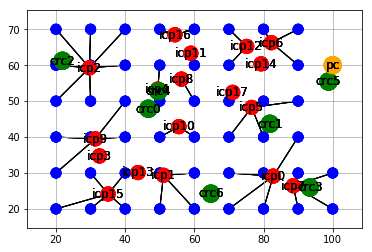

In [92]:
result2 = %timeit -o run_cflp_cplex(G,I,J,W,FCT,q,Q,expid)

1 loop, best of 3: 1.64 s per loop


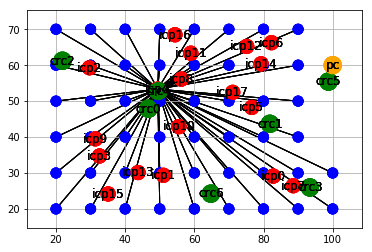

In [93]:
result3 = %timeit -o run_tuflp_cplex(G,I,J,C,c,f,expid)

1 loop, best of 3: 9.75 s per loop


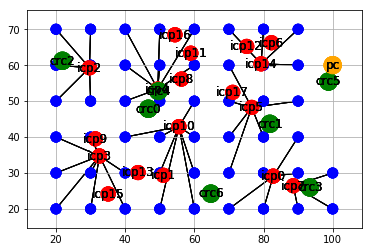

In [94]:
result4 = %timeit -o run_tecflp_cplex(G,I,J,C,c,f,q,V,expid)

In [95]:
from pkg.tecflp_cplex import tecflp_cplex
prob, X, Z = tecflp_cplex(I,J,C,c,f,q,V,
                relaxation=False,path=expid+"/tecflp_cplex.lp")

## Results

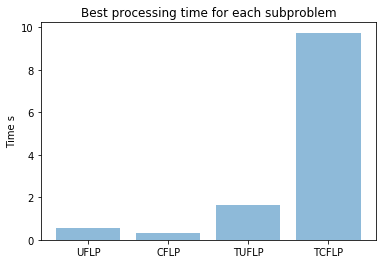

In [96]:
objects = ('UFLP', 'CFLP', 'TUFLP', 'TCFLP')
y_pos = np.arange(len(objects))
performance = [result1.best,result2.best,result3.best,result4.best]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time s')
plt.title('Best processing time for each subproblem')
 
plt.show()